In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [202]:
# Read the dataset into the dataframe
df = pd.read_csv('/content/diabetic_data.csv')

## **EDA**

In [203]:
df.shape # Check the size of the dataset

(101766, 50)

In [204]:
df.info() # Check the overall information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [205]:
df.isnull().sum() # Check the missing values

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
weight,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0


In [206]:
df.duplicated().sum() # Check the duplicate values

np.int64(0)

In [207]:
for i in df.select_dtypes(include='object').columns:
  print(df[i].value_counts())
  print('---' * 10)

race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64
------------------------------
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64
------------------------------
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64
------------------------------
weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64
------------------------------
payer_code
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549

In [208]:
df.describe().T # Check the numerical data values

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


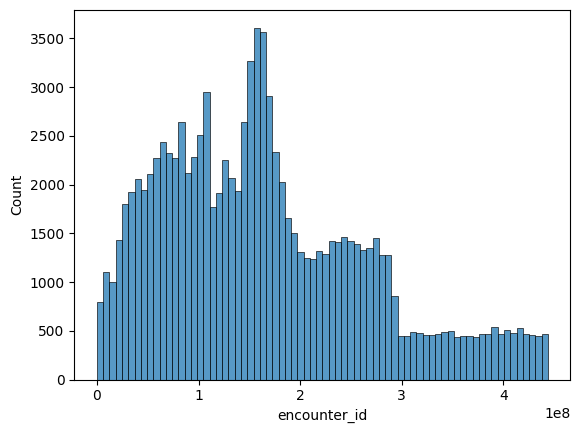

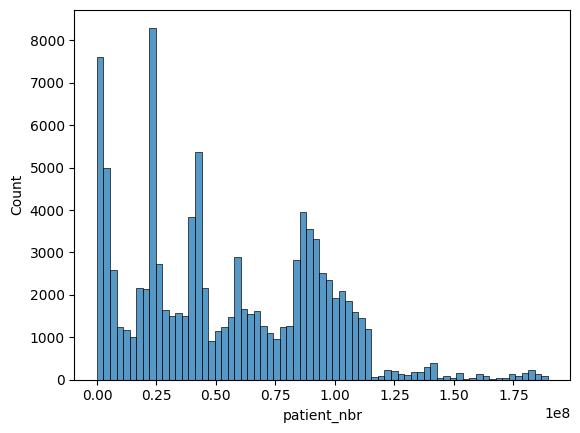

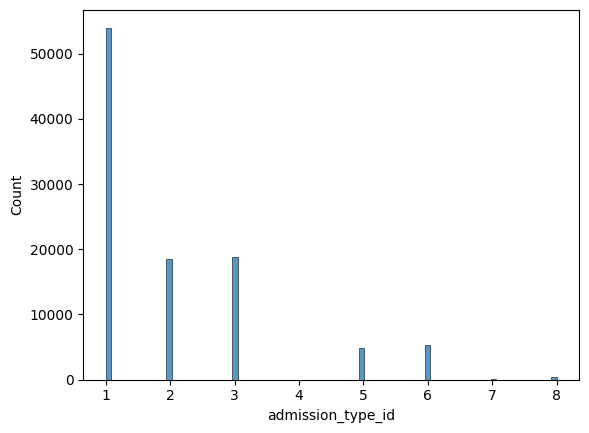

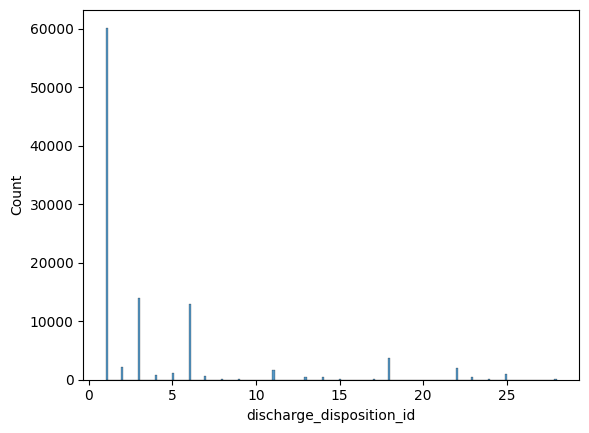

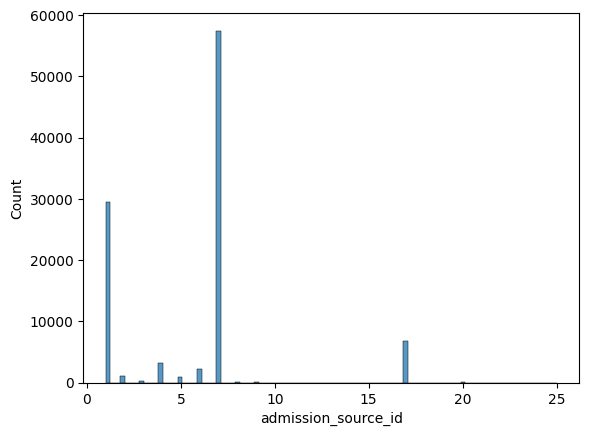

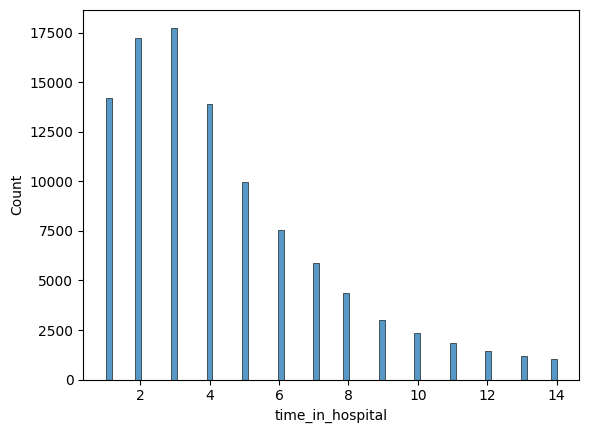

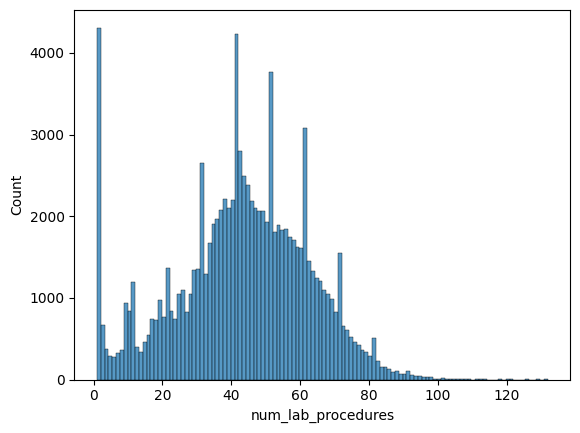

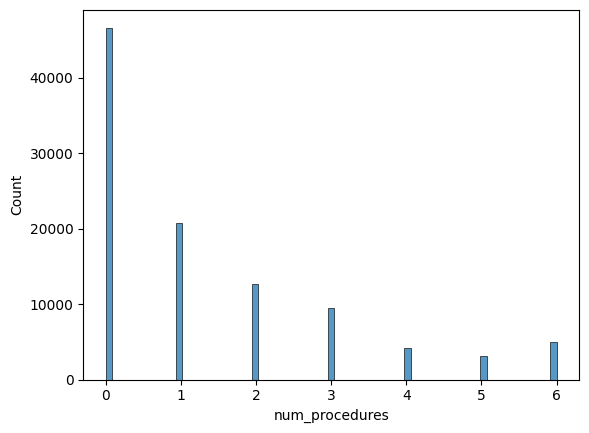

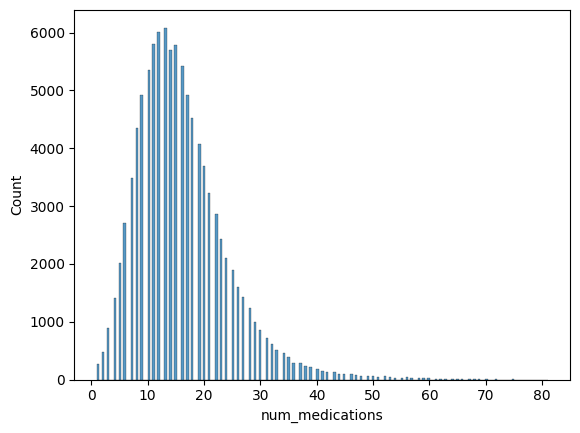

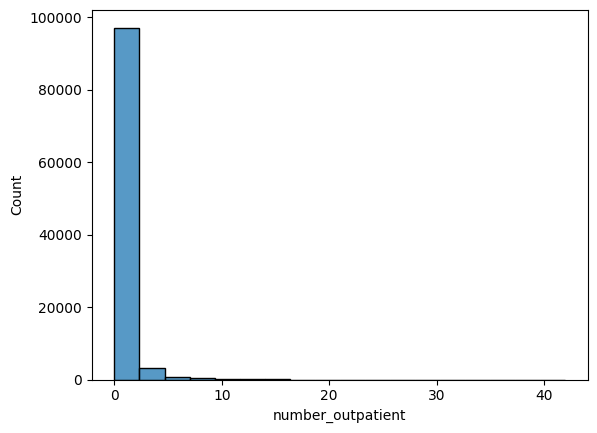

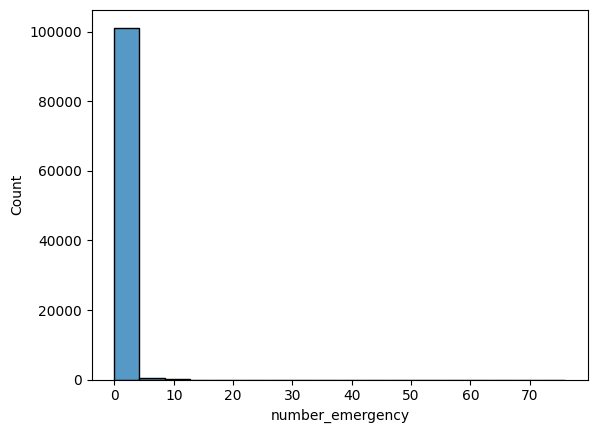

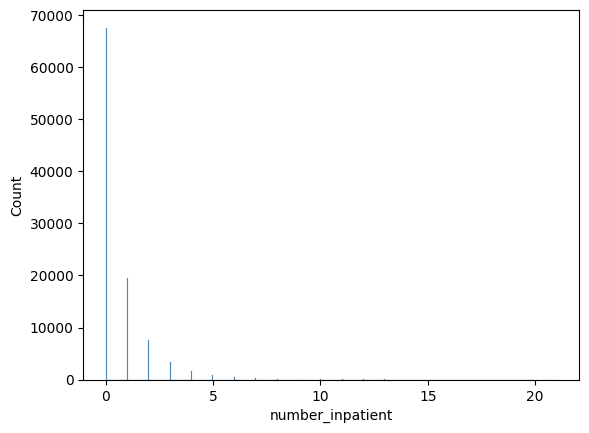

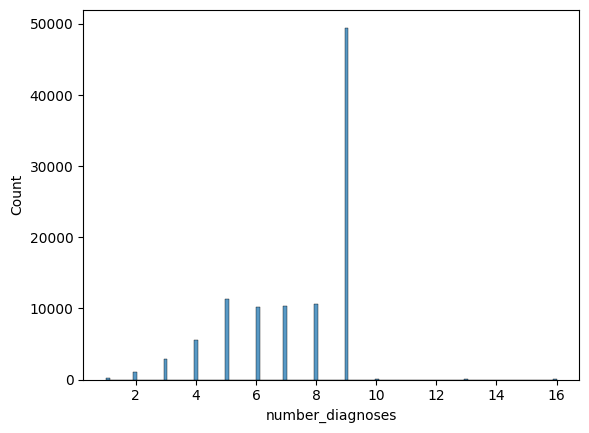

In [209]:
# Histogram to understand the distribution, although i don't get anything 😁
for i in df.select_dtypes(include='number').columns:
  sns.histplot(data = df, x = i)
  plt.show()

<Axes: xlabel='gender'>

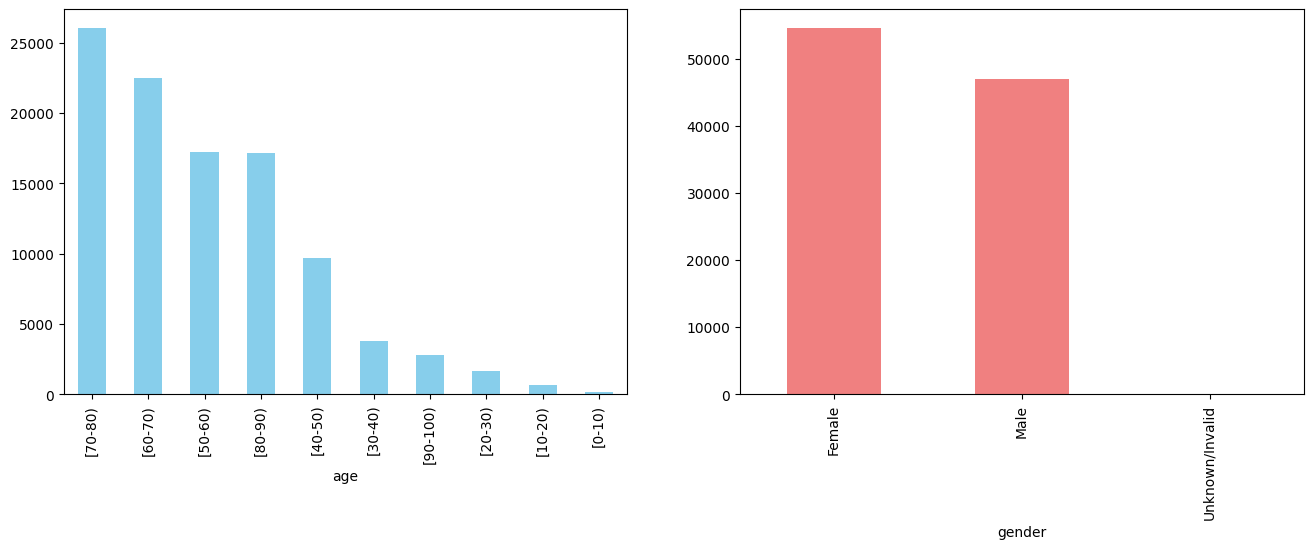

In [210]:
# Age and Gender Count
age_count = df["age"].value_counts()
gender_count = df["gender"].value_counts()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
age_count.plot(kind='bar', ax=ax1, color='skyblue')
gender_count.plot(kind='bar', ax=ax2, color='lightcoral')

<Axes: xlabel='weight'>

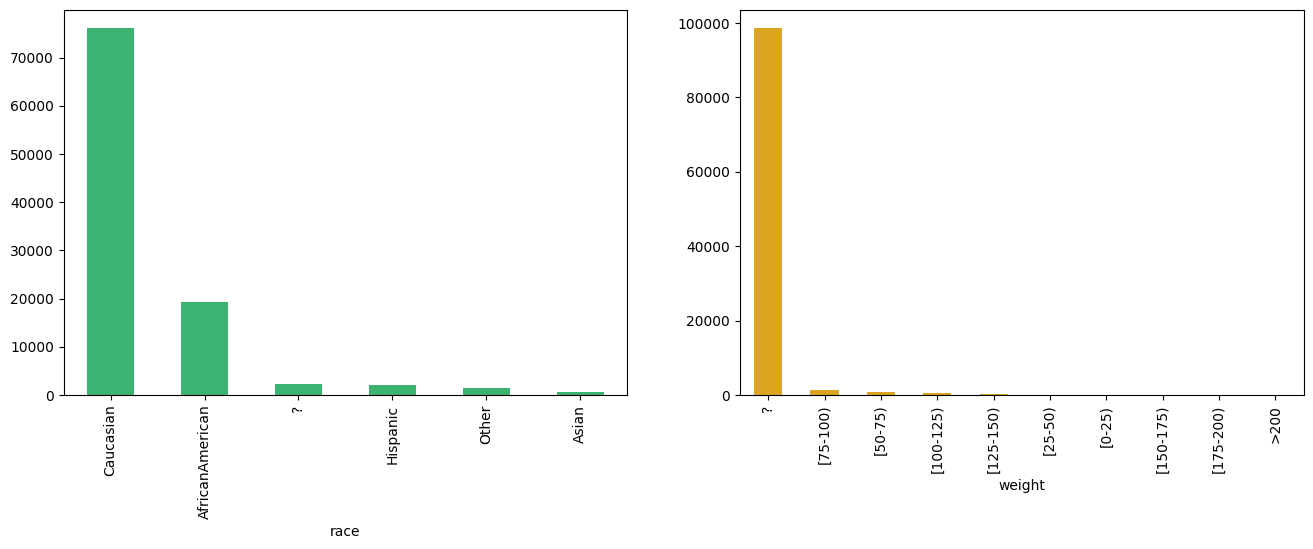

In [211]:
# Race and Weight Count
race_count = df["race"].value_counts()
weight_count = df["weight"].value_counts()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
race_count.plot(kind='bar', ax=ax1, color='mediumseagreen')
weight_count.plot(kind='bar', ax=ax2, color='goldenrod')

<Axes: title={'center': 'Readmission Count'}, xlabel='readmitted'>

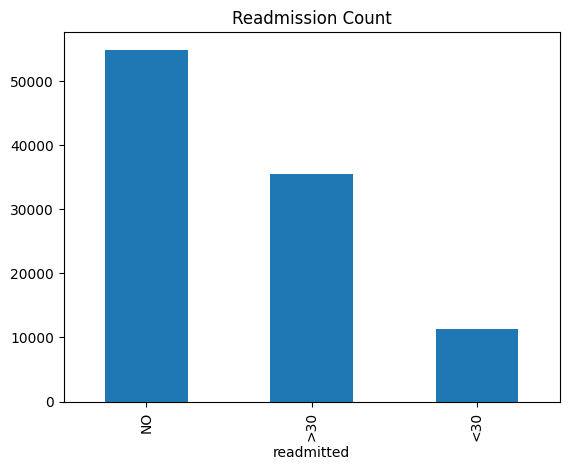

In [212]:
#Readmission Rate Count
target_count = df['readmitted'].value_counts()
target_count.plot(kind = 'bar', title= 'Readmission Count')

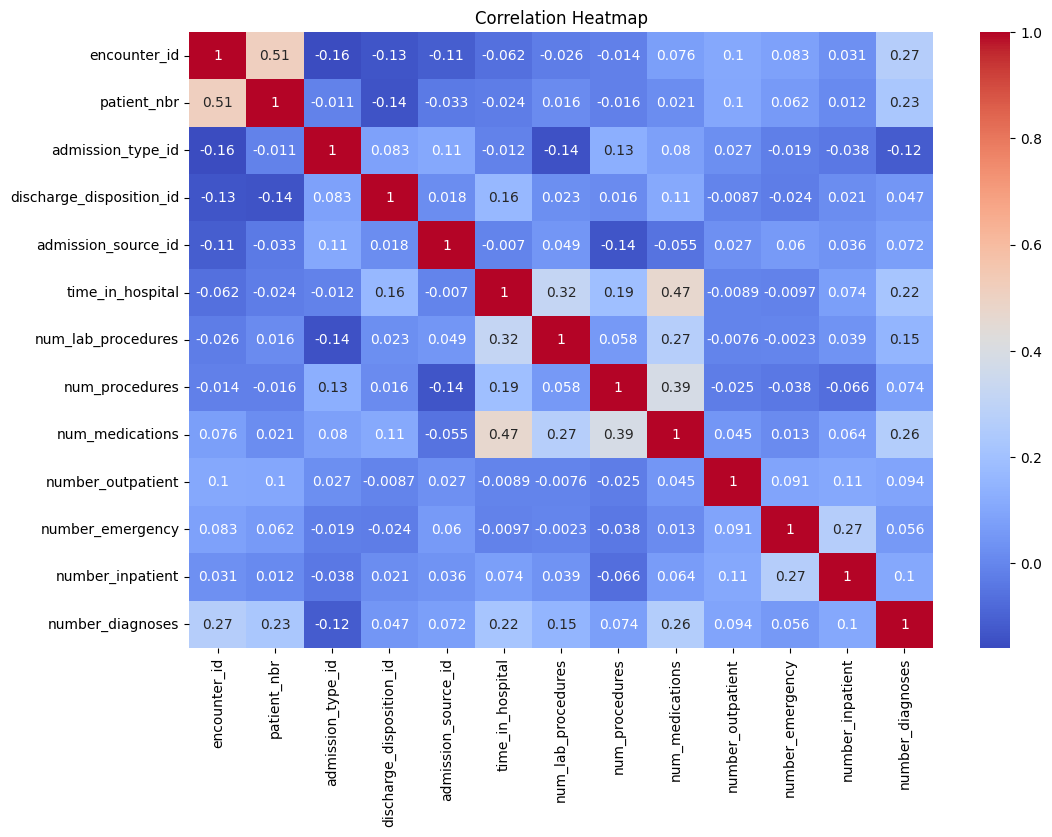

In [213]:
# Correlation Heatmap
corr = df.select_dtypes(include = 'number').corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [214]:
df.columns # To divide them into diagnosis_cols and

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

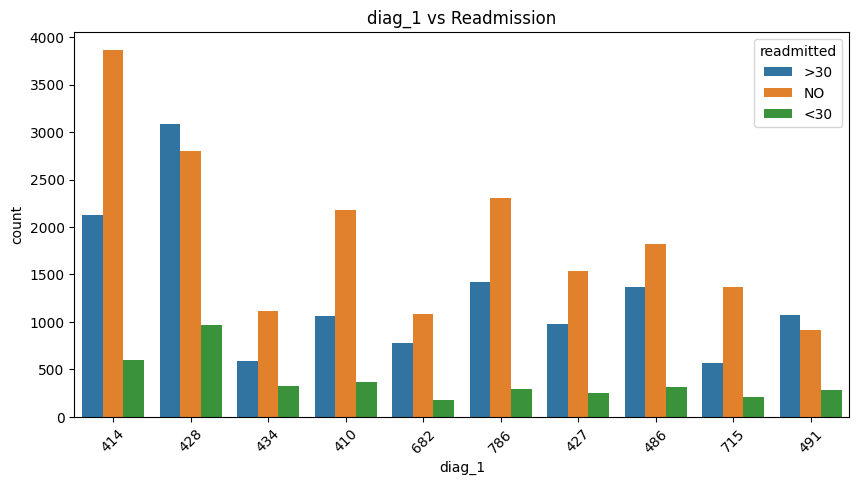

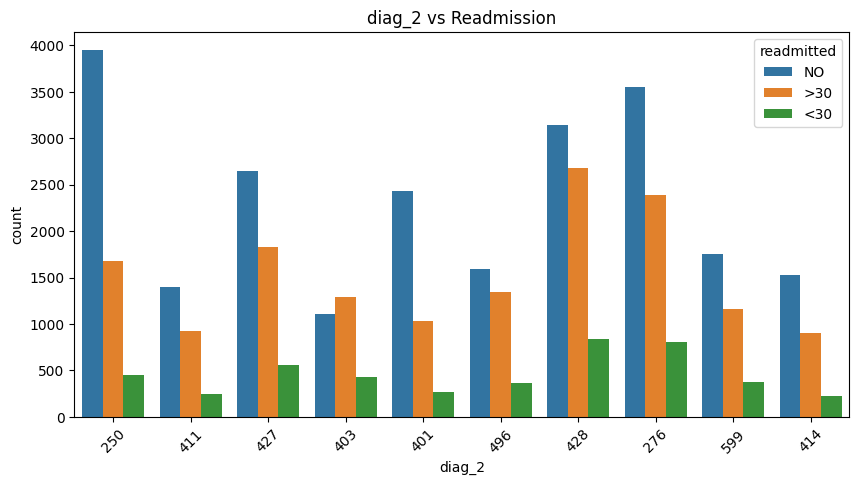

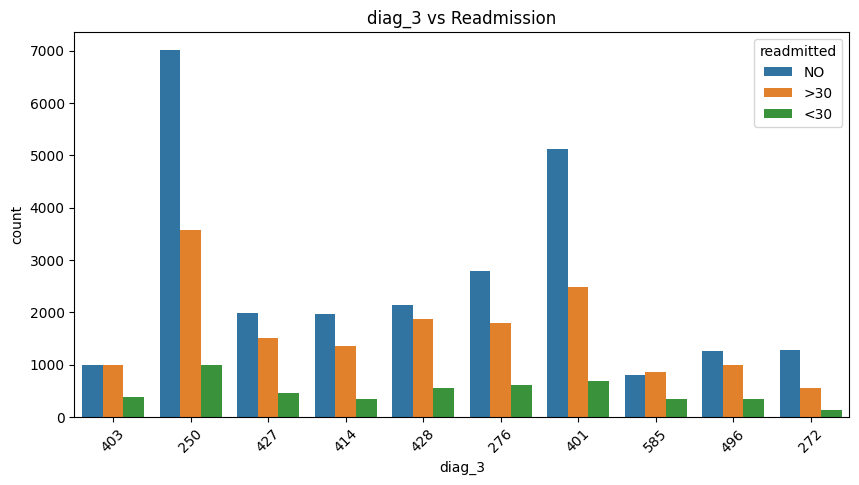

In [215]:
diagnosis_cols = ['diag_1', 'diag_2', 'diag_3']

# Diagnosis vs Readmission
for diag in diagnosis_cols:
    plt.figure(figsize=(10, 5))
    top10 = df[diag].value_counts().iloc[:10].index  # Top 10 frequent diagnoses
    sns.countplot(data=df[df[diag].isin(top10)], x=diag, hue='readmitted')
    plt.title(f'{diag} vs Readmission')
    plt.xticks(rotation=45)
    plt.show()

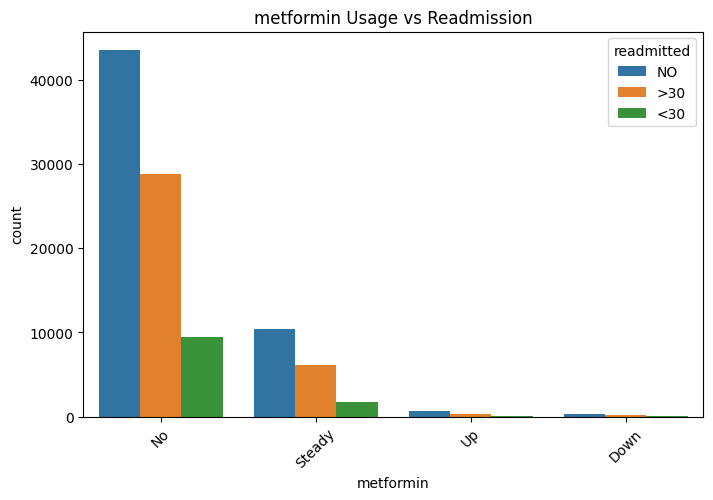

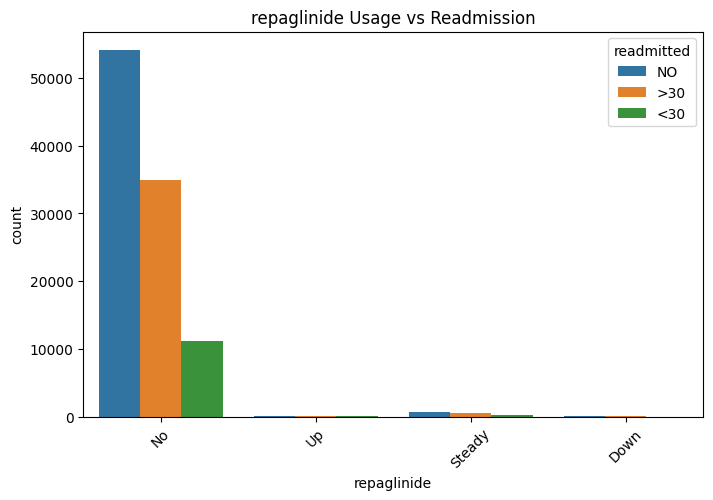

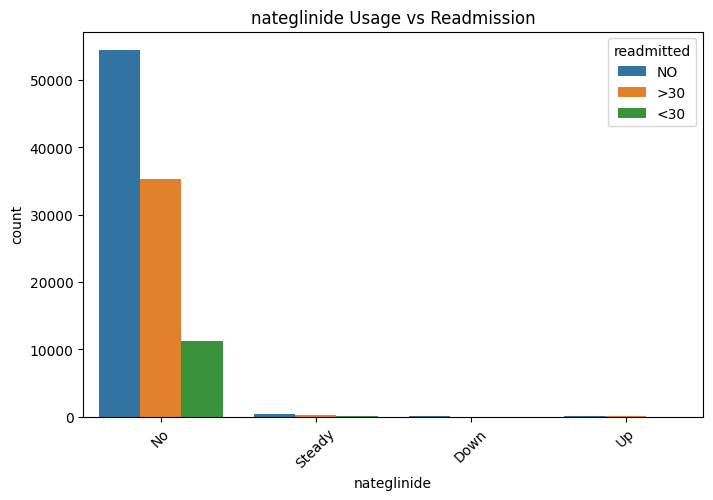

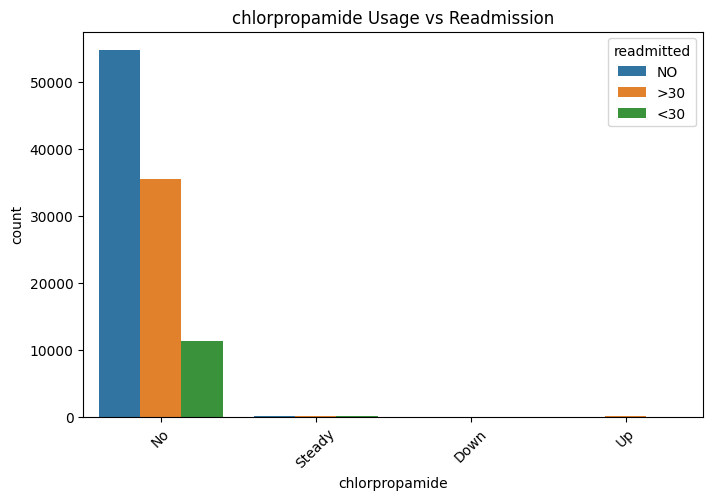

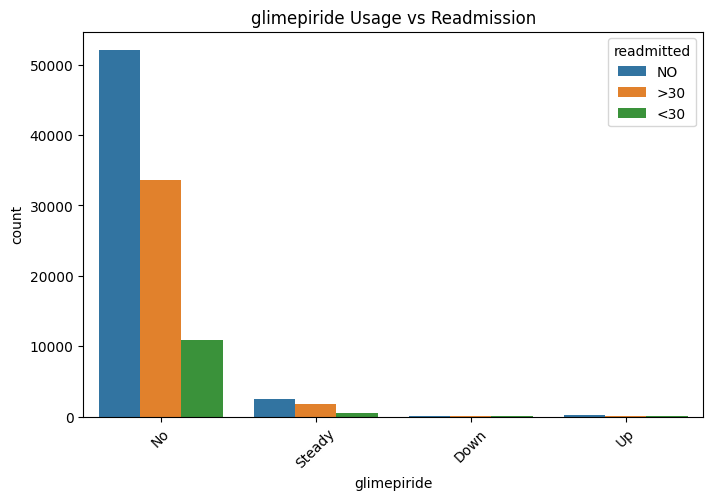

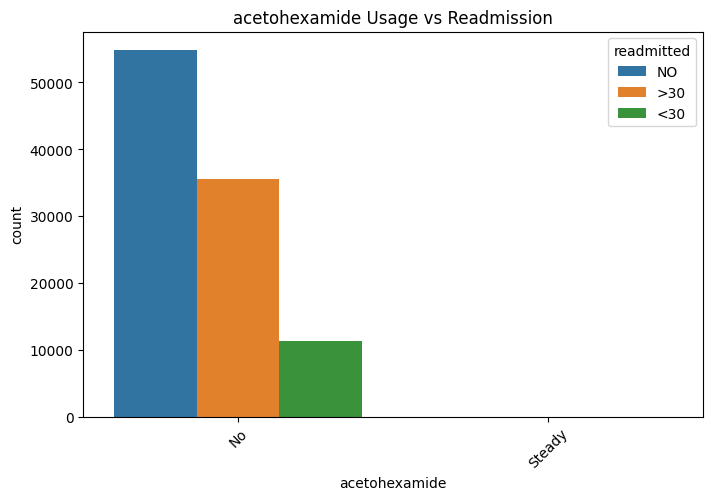

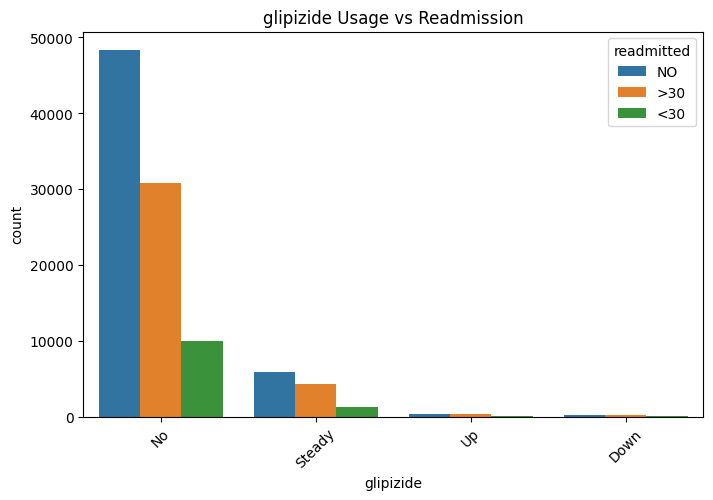

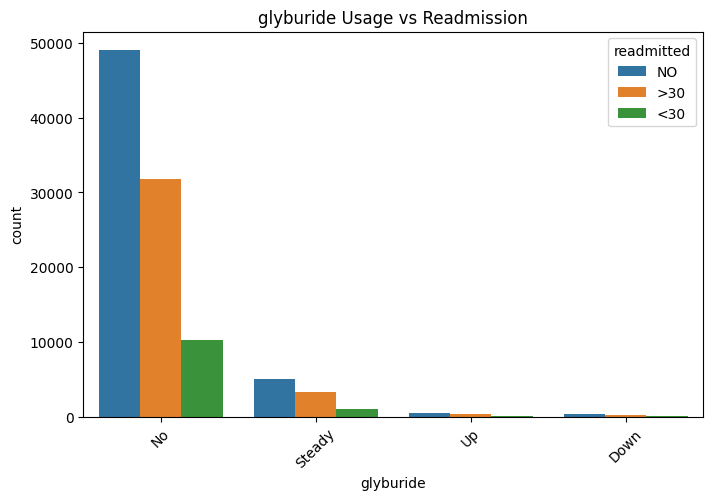

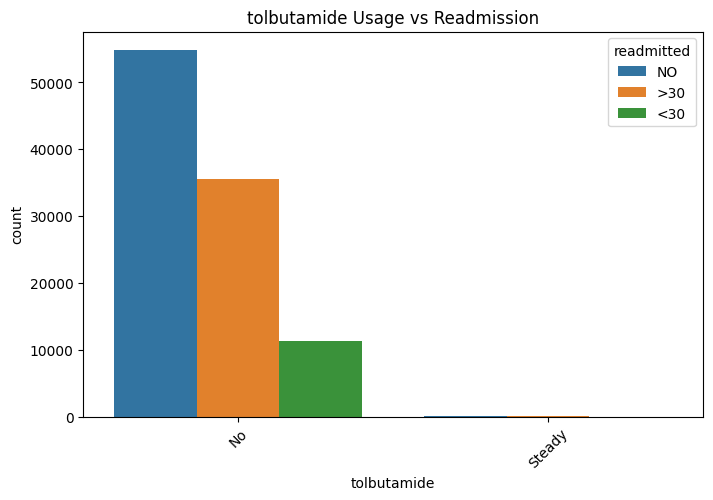

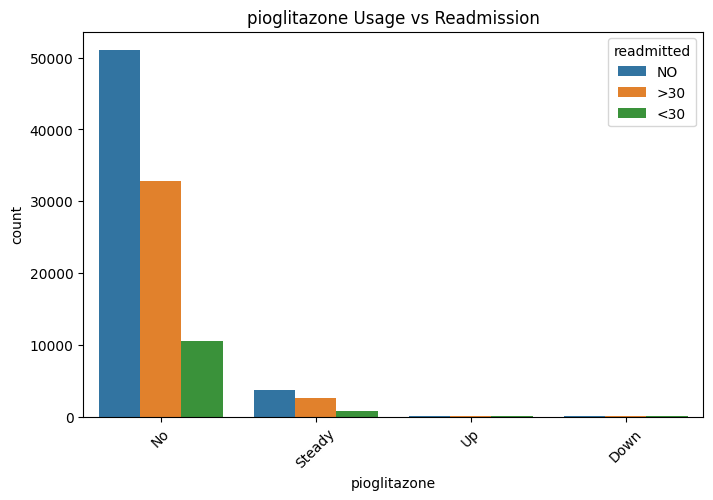

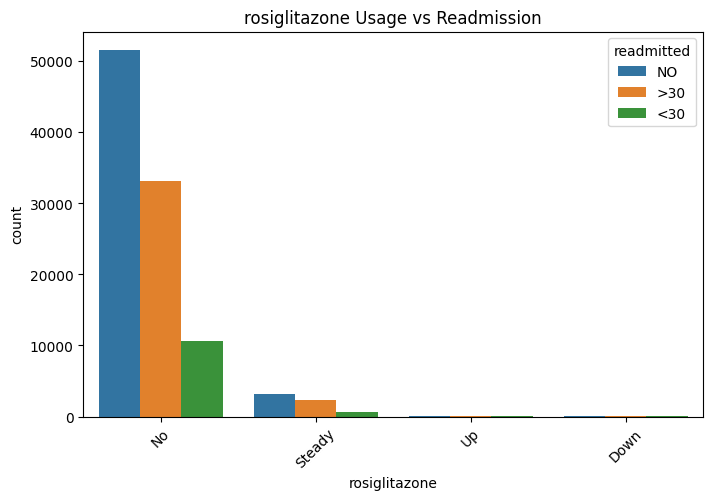

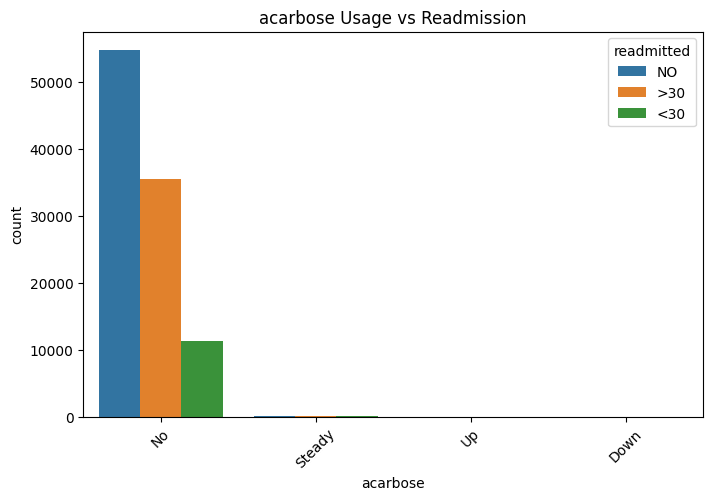

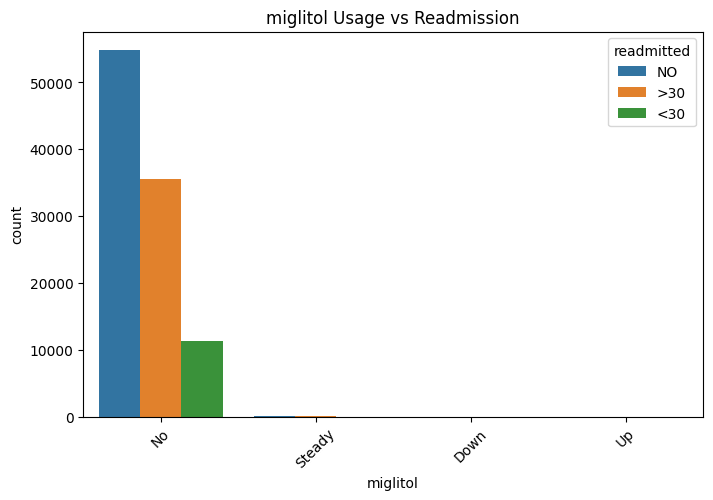

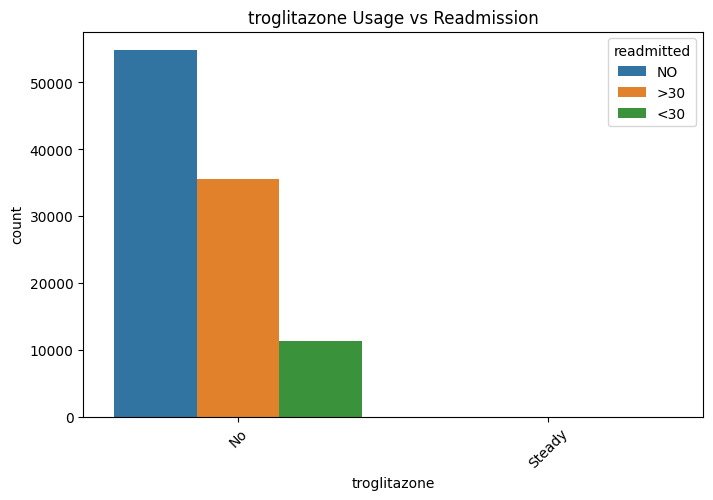

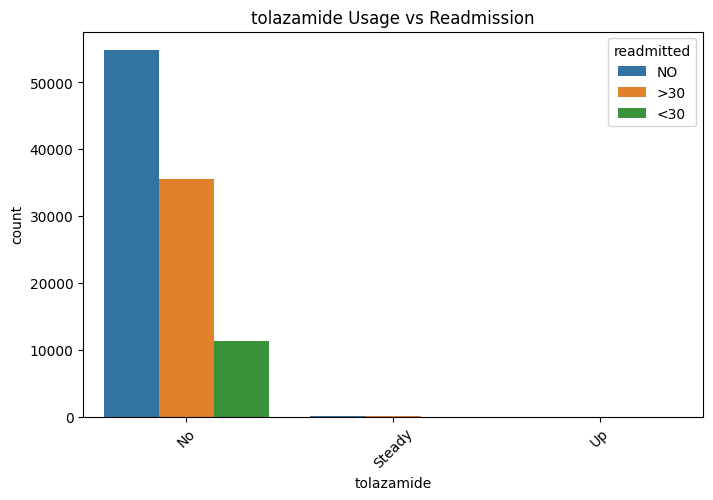

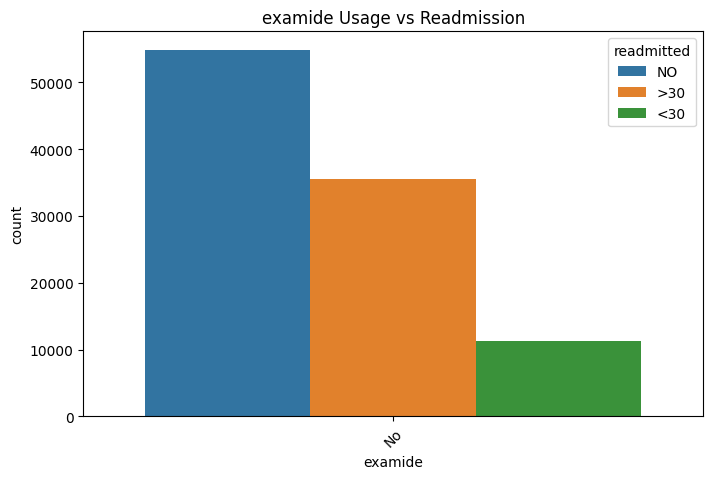

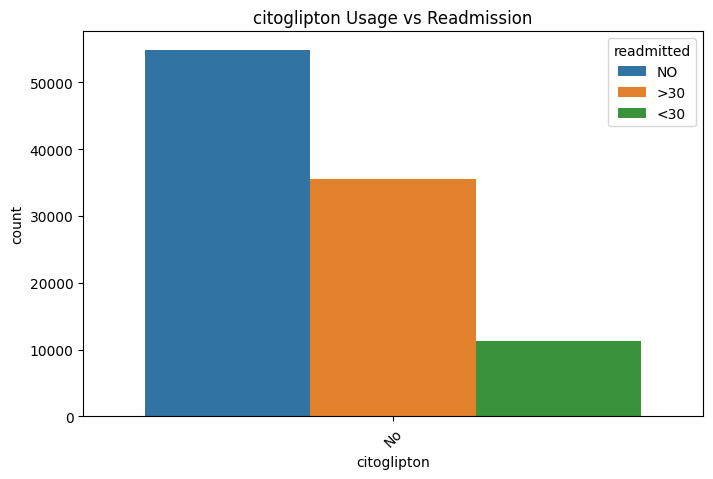

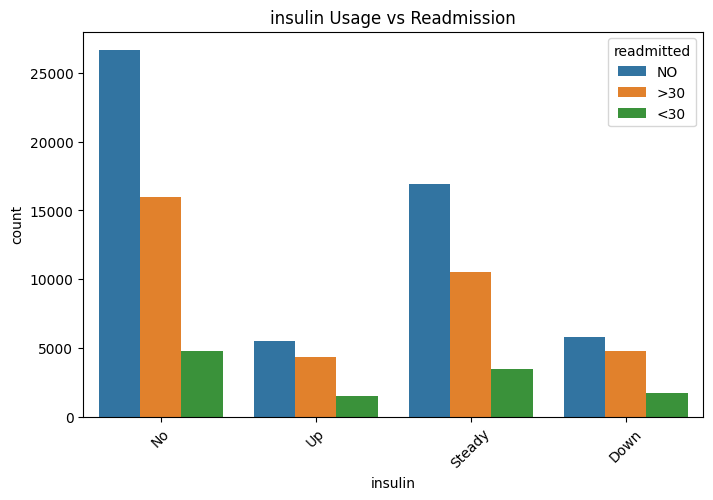

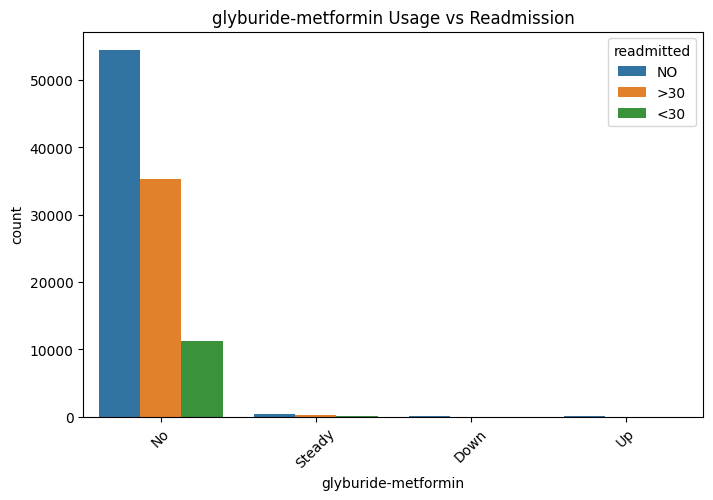

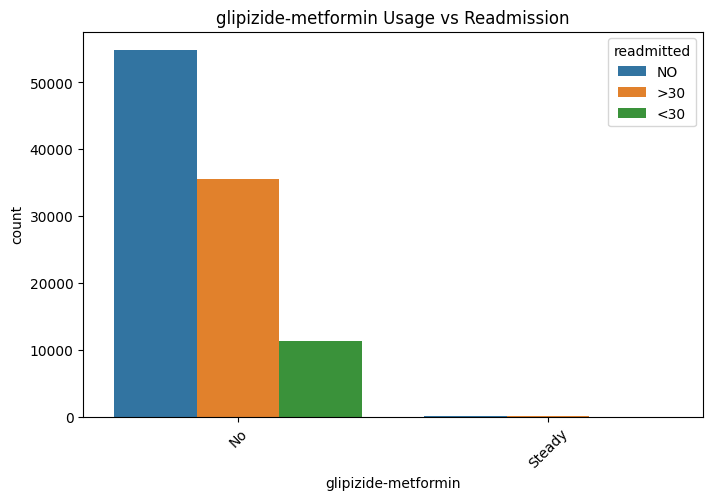

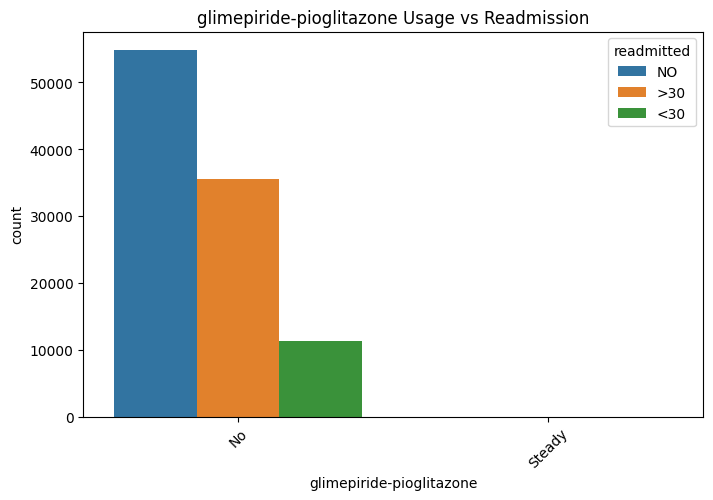

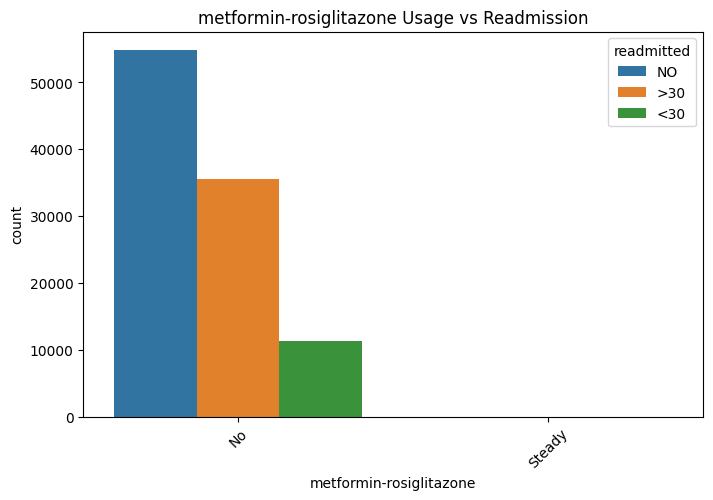

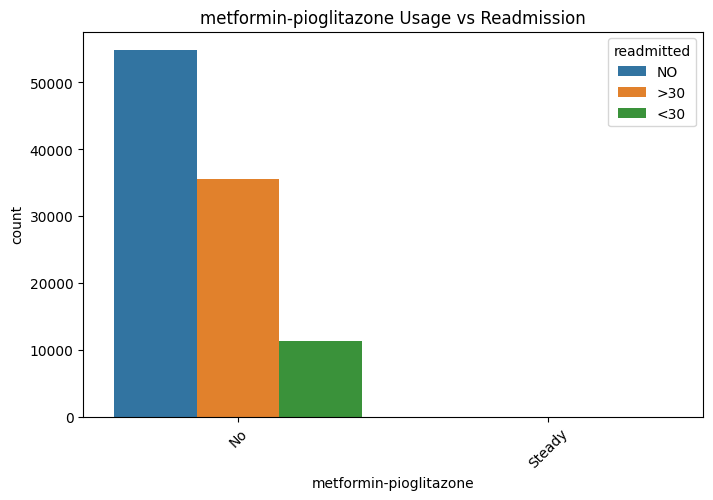

In [216]:
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin',
    'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

# Medications vs Readmission
for med in medication_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=med, hue='readmitted')
    plt.title(f'{med} Usage vs Readmission')
    plt.xticks(rotation=45)
    plt.show()


# **Data Processing**

In [217]:
missing_info = []

# Check missing values for object columns
for col in df.select_dtypes(include = 'object').columns:
        count_missing = df[col][df[col] == '?'].count()
        percent_missing = (count_missing / df.shape[0] * 100).round(2)
        missing_info.append([col, count_missing, percent_missing])

# Create DataFrame from collected missing info
missing_value = pd.DataFrame(missing_info, columns=["col", "count_missing", "percent_missing"])
missing_value = missing_value.sort_values(by="percent_missing", ascending=False)

missing_value

,col,count_missing,percent_missing
3,weight,98569,96.86
5,medical_specialty,49949,49.08
4,payer_code,40256,39.56
0,race,2273,2.23
8,diag_3,1423,1.40
7,diag_2,358,0.35
6,diag_1,21,0.02
1,gender,0,0.00
2,age,0,0.00
9,max_glu_serum,0,0.00


In [218]:
# Drop 3 columns with too many missing '?'
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

# Drop rows based on multiple cleaning conditions:
df = df.drop(df[
    # Drop if all three diagnosis columns are missing ('?')
    ((df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')) |

    # Drop specific 'admission_type_id' values: 5 (Not Available), 6 (NULL), 8 (Not Mapped)
    (df['admission_type_id'].isin([5, 6, 8])) |

    # Drop 'discharge_disposition_id' values indicating death or irrelevant outcomes
    (df['discharge_disposition_id'].isin([11, 13, 14, 18, 19, 20, 21, 25, 26])) |

    # Drop 'admission_source_id' values that are unavailable, NULL, or not mapped
    (df['admission_source_id'].isin([9, 15, 17, 20, 21]))
].index)


In [219]:
df.shape # Check th dimension now

(84377, 47)

In [220]:
# Drop missing values in gender
df = df.drop(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))

# Drop missing values in race
df = df.drop(set(df['race'][df['race']=='?'].index))

In [221]:
df.shape # Check th dimension now

(82367, 47)

In [222]:
# Drop irrelevant variables
df = df.drop(["encounter_id","patient_nbr"],axis=1)
df = df.drop(["citoglipton","examide"],axis = 1)

In [223]:
df.shape # Check th dimension now

(82367, 43)

In [224]:
df['readmitted'].value_counts() # Just to check the difference

,count
readmitted,
NO,43322
>30,29592
<30,9453


In [225]:
df.isnull().sum()

,0
race,0
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
num_lab_procedures,0
num_procedures,0
num_medications,0


In [226]:
# Drop max_glu_serum because it's almost entirely missing
df.drop('max_glu_serum', axis=1, inplace=True)

# Fill A1Cresult missing values with 'None'
df['A1Cresult'] = df['A1Cresult'].fillna('None')

In [227]:
df.shape # Check th dimension now

(82367, 42)

In [228]:
# Decoding IDs using mapping file
admission_type_map = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    7: 'Trauma Center',
}

discharge_disposition_map = {
    1: 'Discharged to home',
    2: 'Discharged/transferred to another short term hospital',
    3: 'Discharged/transferred to SNF',
    4: 'Discharged/transferred to ICF',
    5: 'Discharged/transferred to another type of inpatient care institution',
    6: 'Discharged/transferred to home with home health service',
    7: 'Left AMA',
    8: 'Discharged/transferred to home under care of Home IV provider',
    9: 'Admitted as an inpatient to this hospital',
    10: 'Neonate discharged to another hospital for neonatal aftercare',
    12: 'Still patient or expected to return for outpatient services',
    15: 'Discharged/transferred within this institution to Medicare approved swing bed',
    16: 'Discharged/transferred/referred another institution for outpatient services',
    17: 'Discharged/transferred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
    22: 'Discharged/transferred to another rehab facility including rehab units of a hospital',
    23: 'Discharged/transferred to a long term care hospital',
    24: 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare',
}

admission_source_map = {
    1: 'Physician Referral',
    2: 'Clinic Referral',
    3: 'HMO Referral',
    4: 'Transfer from a hospital',
    5: 'Transfer from a Skilled Nursing Facility (SNF)',
    6: 'Transfer from another health care facility',
    7: 'Emergency Room',
    8: 'Court/Law Enforcement',
    10: 'Transfer from critical access hospital',
    11: 'Normal Delivery',
    12: 'Premature Delivery',
    13: 'Sick Baby',
    14: 'Extramural Birth',
}

df['admission_type_id'] = df['admission_type_id'].replace(admission_type_map)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(discharge_disposition_map)
df['admission_source_id'] = df['admission_source_id'].replace(admission_source_map)

In [229]:
# Adding some important features
df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['missing_diag'] = ((df['diag_1'] == '?') | (df['diag_2'] == '?') | (df['diag_3'] == '?')).astype(int)

# List of medication columns
meds_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide',
    'metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone',
    'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide'
]

# Create new binary columns: 1 if med was changed (up or down), 0 if no change or steady (Some encoding)
for col in meds_cols:
    new_col = f"{col}_new"
    df[new_col] = df[col].apply(lambda x: 0 if x in ['No', 'Steady'] else 1)

# Sum up all the med changes to create a 'med_change' feature
df['med_change'] = df[[f"{col}_new" for col in meds_cols]].sum(axis=1)

# Drop the temporary binary columns
df.drop(columns=[f"{col}_new" for col in meds_cols], inplace=True)

In [230]:
df['med_change'].value_counts()

,count
med_change,
0,59636
1,21531
2,1098
3,97
4,5


In [231]:
# Recode medication columns: 'No' → 0, all others ('Steady', 'Up', 'Down') → 1
for col in meds_cols:
    df[col] = df[col].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})

# Create 'num_med' feature: sum across the medication columns
df['num_med'] = df[meds_cols].sum(axis=1)

<ipython-input-231-bd93be66fe2e>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})


In [232]:
df['num_med'].value_counts()

,count
num_med,
1,38061
0,18295
2,18152
3,6627
4,1175
5,55
6,2


In [233]:
# calculate the outcome variable readmission
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [234]:
# Encode Age
df['age_num'] = df['age'].str.extract('(\d+)', expand=False).astype(int) + 5

In [235]:
df['age_num'].value_counts()

,count
age_num,
75,20557
65,18467
55,14259
85,13655
45,7907
35,3163
95,2158
25,1429
15,627


In [236]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'total_visits', 'missing_diag', 'med_change', 'num_med', 'age_num'],
      dtype='object')

In [237]:
df['high_A1C_flag'] = df['A1Cresult'].isin(['>7', '>8']).astype(int)

In [238]:
from sklearn.preprocessing import LabelEncoder

# Label Encode 'race', 'A1Cresult', 'max_glu_serum'
label_cols = ['race', 'A1Cresult']

# Initialize LabelEncoder
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])

In [239]:
df['diag_1'].value_counts()

,count
diag_1,
428,5542
414,5392
786,3185
410,2773
486,2763
...,...
976,1
363,1
842,1


In [240]:
# Safe numeric conversion first
df['diag_1_num'] = pd.to_numeric(df['diag_1'], errors='coerce')
df['diag_2_num'] = pd.to_numeric(df['diag_2'], errors='coerce')
df['diag_3_num'] = pd.to_numeric(df['diag_3'], errors='coerce')

# Initialize new columns
df['diag_1_code'] = 0
df['diag_2_code'] = 0
df['diag_3_code'] = 0

# Mapping for diag_1
df.loc[df['diag_1'].astype(str).str.startswith('V'), 'diag_1_code'] = 1
df.loc[df['diag_1'].astype(str).str.startswith('E'), 'diag_1_code'] = 2
df.loc[((df['diag_1_num'] >= 390) & (df['diag_1_num'] < 460)) | (df['diag_1_num'] == 785), 'diag_1_code'] = 3
df.loc[((df['diag_1_num'] >= 460) & (df['diag_1_num'] < 520)) | (df['diag_1_num'] == 786), 'diag_1_code'] = 4
df.loc[((df['diag_1_num'] >= 520) & (df['diag_1_num'] < 580)) | (df['diag_1_num'] == 787), 'diag_1_code'] = 5
df.loc[(df['diag_1_num'] >= 250) & (df['diag_1_num'] < 251), 'diag_1_code'] = 6
df.loc[(df['diag_1_num'] >= 800) & (df['diag_1_num'] < 1000), 'diag_1_code'] = 7
df.loc[(df['diag_1_num'] >= 710) & (df['diag_1_num'] < 740), 'diag_1_code'] = 8
df.loc[((df['diag_1_num'] >= 580) & (df['diag_1_num'] < 630)) | (df['diag_1_num'] == 788), 'diag_1_code'] = 9
df.loc[(df['diag_1_num'] >= 140) & (df['diag_1_num'] < 240), 'diag_1_code'] = 10

# Mapping for diag_2
df.loc[df['diag_2'].astype(str).str.startswith('V'), 'diag_2_code'] = 1
df.loc[df['diag_2'].astype(str).str.startswith('E'), 'diag_2_code'] = 2
df.loc[((df['diag_2_num'] >= 390) & (df['diag_2_num'] < 460)) | (df['diag_2_num'] == 785), 'diag_2_code'] = 3
df.loc[((df['diag_2_num'] >= 460) & (df['diag_2_num'] < 520)) | (df['diag_2_num'] == 786), 'diag_2_code'] = 4
df.loc[((df['diag_2_num'] >= 520) & (df['diag_2_num'] < 580)) | (df['diag_2_num'] == 787), 'diag_2_code'] = 5
df.loc[(df['diag_2_num'] >= 250) & (df['diag_2_num'] < 251), 'diag_2_code'] = 6
df.loc[(df['diag_2_num'] >= 800) & (df['diag_2_num'] < 1000), 'diag_2_code'] = 7
df.loc[(df['diag_2_num'] >= 710) & (df['diag_2_num'] < 740), 'diag_2_code'] = 8
df.loc[((df['diag_2_num'] >= 580) & (df['diag_2_num'] < 630)) | (df['diag_2_num'] == 788), 'diag_2_code'] = 9
df.loc[(df['diag_2_num'] >= 140) & (df['diag_2_num'] < 240), 'diag_2_code'] = 10

# Mapping for diag_3
df.loc[df['diag_3'].astype(str).str.startswith('V'), 'diag_3_code'] = 1
df.loc[df['diag_3'].astype(str).str.startswith('E'), 'diag_3_code'] = 2
df.loc[((df['diag_3_num'] >= 390) & (df['diag_3_num'] < 460)) | (df['diag_3_num'] == 785), 'diag_3_code'] = 3
df.loc[((df['diag_3_num'] >= 460) & (df['diag_3_num'] < 520)) | (df['diag_3_num'] == 786), 'diag_3_code'] = 4
df.loc[((df['diag_3_num'] >= 520) & (df['diag_3_num'] < 580)) | (df['diag_3_num'] == 787), 'diag_3_code'] = 5
df.loc[(df['diag_3_num'] >= 250) & (df['diag_3_num'] < 251), 'diag_3_code'] = 6
df.loc[(df['diag_3_num'] >= 800) & (df['diag_3_num'] < 1000), 'diag_3_code'] = 7
df.loc[(df['diag_3_num'] >= 710) & (df['diag_3_num'] < 740), 'diag_3_code'] = 8
df.loc[((df['diag_3_num'] >= 580) & (df['diag_3_num'] < 630)) | (df['diag_3_num'] == 788), 'diag_3_code'] = 9
df.loc[(df['diag_3_num'] >= 140) & (df['diag_3_num'] < 240), 'diag_3_code'] = 10

# Optional: Drop intermediate numeric columns if you want
df.drop(['diag_1_num', 'diag_2_num', 'diag_3_num'], axis=1, inplace=True)

In [241]:
df['diag_1_code'].value_counts()

,count
diag_1_code,
3,24550
0,13485
4,11403
5,7729
6,7307
7,5777
9,4263
8,3965
10,2613


In [242]:
df.shape

(82367, 51)

In [243]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'total_visits', 'missing_diag', 'med_change', 'num_med', 'age_num',
       'high_A1C_flag', 'diag_1_code', 'diag_2_code', 'diag_3_code'],
      dtype='object')

In [244]:
num_col = list(set(list(df._get_numeric_data().columns))- {'readmitted'})
num_col

['acetohexamide',
 'glimepiride',
 'rosiglitazone',
 'missing_diag',
 'A1Cresult',
 'glimepiride-pioglitazone',
 'diag_1_code',
 'num_procedures',
 'tolazamide',
 'num_med',
 'med_change',
 'metformin',
 'number_inpatient',
 'glipizide',
 'acarbose',
 'insulin',
 'metformin-rosiglitazone',
 'total_visits',
 'age_num',
 'num_lab_procedures',
 'time_in_hospital',
 'repaglinide',
 'diag_3_code',
 'high_A1C_flag',
 'tolbutamide',
 'number_emergency',
 'glyburide-metformin',
 'pioglitazone',
 'num_medications',
 'number_outpatient',
 'glyburide',
 'nateglinide',
 'metformin-pioglitazone',
 'glipizide-metformin',
 'diag_2_code',
 'race',
 'chlorpropamide',
 'miglitol',
 'number_diagnoses',
 'troglitazone']

In [245]:
def standardize(data):
    return ((data - np.mean(data, axis = 0)) / np.std(data, axis = 0))
# num_col is a list of all numeric features
df[num_col] = standardize(df[num_col])

In [246]:
# Handle outliers for all numerical columns

for col in num_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip the outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [247]:
df.shape

(82367, 51)

In [248]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'total_visits', 'missing_diag', 'med_change', 'num_med', 'age_num',
       'high_A1C_flag', 'diag_1_code', 'diag_2_code', 'diag_3_code'],
      dtype='object')

In [249]:
# Columns that are categorical (object type) and need encoding
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Apply LabelEncoder to each categorical column
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [250]:
df['readmitted'].value_counts()

,count
readmitted,
0,72914
1,9453


In [251]:
df.isnull().sum() # high_A1C_flag, metformin-rosiglitazone

,0
race,0
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
num_lab_procedures,0
num_procedures,0
num_medications,0


In [252]:
df = df.drop(['metformin-rosiglitazone', 'high_A1C_flag'], axis = 1)

In [253]:
# Test just see if all of the above came with profit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Split features and target
x = df.drop('readmitted', axis=1)
y = df['readmitted']

# Stratified train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

# Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(x_train, y_train)

# Predict on test set
y_pred = model.predict(x_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print all results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Accuracy: 0.6564283112783781
Precision: 0.1751422168591622
Recall: 0.5372818614489688
F1 Score: 0.2641705668226729
Confusion Matrix:
 [[9798 4785]
 [ 875 1016]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.78     14583
           1       0.18      0.54      0.26      1891

    accuracy                           0.66     16474
   macro avg       0.55      0.60      0.52     16474
weighted avg       0.83      0.66      0.72     16474



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
